# Applying the Principle of Majorization to Random Quantum Circuits with myQLM

This program aims to reproduce the results in the article *Principle of majorization: Application to random quantum circuits* by *Raúl O. Vallejos, Fernando de Melo, and Gabriel G. Carlo* [1].

## Physical motivation

Consider a system described by a probability vector $P(t)$

<br>
<div><center>
    <img src="systemevo.png" width="500"/></center>
</div>
<br>

The ***Principle of Increasing Mixing Character*** [2-4] states that:

$$ \sum_{i=1}^{k}P(t_2)_{i}^{\downarrow}\leq\sum_{i=1}^{k}P(t_1)_{i}^{\downarrow}, $$

or $P(t_2) \prec P(t_1)$.  This principle is a **stronger version of the Second Law of Thermodynamics** in the sense that it expresses that the increase in the Shanon entropy of a system over time.

An interesting visual way to see majorization relations is using a ***Lorenz curve***, with is a plot that shows the relation between the partial sums in the above equation, the **cumulants**, as $k/N$ increases.

<br>
<div><center>
    <img src="lorenz.png" width="300"/></center>
</div>
<br>

In many fast and effecient quantum algorithms, however, it is found that the description of the system at **later** times majorizes the description at **earlier** times, in other words, **the system is evolving in a way that the order is increasing** [5,6].

The objective of article [1] was to analyze this and see if it could lead to a criteria to classify the complexity of a quantum computation.

## The Random Quantum Circuits

The numerical results in [1] were obtained considering unitary quantum circuits with $n=8$ qubit lines. Fixed a gateset $\mathcal{G}$, at each point in time, a random gate is chosen from $\mathcal{G}$ and applied to a random set of qubits. For each step, the state is evaluated in the computational basis, as well as the associated probabilities and cumulants. This is repeated for $N$ steps.

### Initial state of the circuit

The initial states used in the quantum circuits are always completely factorized, i.e,

$$ \left | \psi  \right \rangle = \left | \psi_1  \right \rangle \otimes \dots \otimes \left | \psi_n  \right \rangle $$

For most gatesets, each state is a random Haar distributed state.

In [1]:
from qat.lang.AQASM import QRoutine, AbstractGate, Program
from qat.core.simutil import wavefunction
from qat.qpus import PyLinalg
import random
import numpy as np

# this function generates a random 2x2 matrix #
def random_unitary(dummy=0):
    z = (np.random.randn(2,2) + 1j*np.random.randn(2,2))/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

# this defines a gate that applies a random unitary to a qubit #
random_gate= AbstractGate("random", [float], matrix_generator=random_unitary, arity=1)

# this routine randomizes all qubits #
def randomize_all(nqbits):
    randomize_all_routine = QRoutine()
    wires = randomize_all_routine.new_wires(nqbits)
    for i in range(nqbits):
        randomize_all_routine.apply(random_gate(i), wires[i])
    return randomize_all_routine

# example of implementation #

nqbits=2 # the number of qubits #

my_program = Program()
qbits_reg = my_program.qalloc(nqbits)
qpu = PyLinalg()

my_program.apply(randomize_all(nqbits),qbits_reg)

circuit = my_program.to_circ()
wf=wavefunction(circuit, qpu)

%qatdisplay --svg circuit

print("This is the wave function")
print(wf)

This is the wave function
[-0.39353023-0.34798229j -0.07394143+0.75485763j  0.1848202 -0.11861219j
 -0.29517885-0.11578852j]


### Implementation of the random circuits constructed from a few generators

In [2]:
from qat.lang.AQASM import H, CNOT, X, S, T

# defining the gatesets used in the random circuit routine #

G1=[H, X, CNOT]
G2=[CNOT, H, S]
G3=[CNOT, H, T]

# this routine applies a random gate from a gateset of type 1 to a random qubit #
def random_circuit(nqbits, batchsize, gateset):
    random_circuit_routine = QRoutine()
    wires = random_circuit_routine.new_wires(nqbits)
    for i in range(batchsize):
        chosengate=random.choice(gateset)
        if chosengate.arity==1:
            randomchoice=random.choice(range(nqbits))
            random_circuit_routine.apply(chosengate, randomchoice)
        if chosengate.arity==2:
            randomchoice=random.sample(range(nqbits), 2)
            random_circuit_routine.apply(chosengate, randomchoice[0],randomchoice[1])      
    return random_circuit_routine

#showing an example of a random circuit#

nqbits=3 # the number of qubits #
batchsize=6 # the number of gates to be applied #

my_program = Program()
qbits_reg = my_program.qalloc(nqbits)
my_program.apply(random_circuit(nqbits, batchsize, G3), qbits_reg)
circuit = my_program.to_circ()

%qatdisplay --svg circuit

### Implementation of matchgate circuits

In [3]:
def matchgate(dummy=0):
    A=random_unitary()
    B=random_unitary()
    B=B/np.sqrt(np.linalg.det(B))*np.sqrt(np.linalg.det(A))
    gate = np.array([[A[0,0], 0, 0, A[0,1]],
                     [0, B[0,0], B[0,1], 0],
                     [0, B[1,0], B[1,1], 0],
                     [A[1,0], 0, 0, A[1,1]]])
    return gate

def mg():
    return matchgate(random.random())

# this is the matchgate routine #
def matchgate_routine(nqbits, batchsize):
    matchgate_routine = QRoutine()
    wires = matchgate_routine.new_wires(nqbits)
    for i in range(batchsize):
        randomchoice=random.sample(range(nqbits), 2)
        matchgate_routine.apply(mg(), randomchoice[0],randomchoice[1])
    return matchgate_routine


nqbits=4 # the number of qubits #
batchsize=3



# this defines a gate that applies a random diagonal to a qubit #
matchgate= AbstractGate("match", [float], matrix_generator=matchgate, arity=2)

my_program = Program()
qbits_reg = my_program.qalloc(nqbits)
#for i in range(batchsize):
   # randomchoice=random.sample(range(nqbits), 2)
  #  my_program.apply(matchgate(i), qbits_reg[randomchoice[0]],qbits_reg[randomchoice[1]])

my_program.apply(matchgate_routine(nqbits, batchsize), qbits_reg)

circuit = my_program.to_circ()

%qatdisplay --svg circuit

In [4]:
my_program = Program()
qbits_reg = my_program.qalloc(4)

my_program.apply(mg(), qbits_reg[0],qbits_reg[1])
my_program.apply(mg(), qbits_reg[2],qbits_reg[3])

circuit = my_program.to_circ()

%qatdisplay --svg circuit

from qat.core.simutil import wavefunction
from qat.qpus import PyLinalg

wf=wavefunction(circuit, qpu) # calculate the wave function after n=batchsize gates applied #

print(wf)

[-0.07817815+0.38441444j  0.        +0.j          0.        +0.j
 -0.14562431+0.40107233j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.48933668-0.25440916j  0.        +0.j          0.        +0.j
 -0.48575509-0.35201684j]


### Implementation of diagonal circuits

In [5]:
import math

# this function generates a random nxn diagonal matrix #
def diag(r):
    q=np.zeros((2**r,2**r))
    for i in range(2**r):
        phi=random.uniform(0,2*math.pi)
        q[i,i]=np.exp(1j*phi)
    return q


d2 = AbstractGate("D2", [float], matrix_generator=lambda dummy: diag(2), arity=2)

d3 = AbstractGate("D3", [float], matrix_generator=lambda dummy: diag(3), arity=3)

dn = AbstractGate("Dn", [int], matrix_generator=diag, arity=nqbits)


# this routine applies a gate to all qubits #
def one_for_all(nqbits, gate):
    one_for_all_routine = QRoutine()
    wires = one_for_all_routine.new_wires(nqbits)
    for i in range(nqbits):
        one_for_all_routine.apply(gate, wires[i])
    return one_for_all_routine

# this is the diagonal gate routine #
def diagonal(r,nqbits):
    diagonal_routine = QRoutine()
    wires = diagonal_routine.new_wires(nqbits)
    diagonal_routine.apply(one_for_all(nqbits,H), wires)
    if r==2:
        total=int(nqbits*(nqbits-1)/2)
        perm=list(permutations(range(nqbits),r))
        sample=random.sample(perm,total)
        for x in sample:
            diagonal_routine.apply(d2(random.random()*10), wires[x[0]],wires[x[1]])
    elif r==3:
        total=int(nqbits*(nqbits-1)*(nqbits-2)/6)
        perm=list(permutations(range(nqbits),r))
        sample=random.sample(perm,total)
        for x in sample:
            diagonal_routine.apply(d3(random.random()*10), wires[x[0]],wires[x[1]],wires[x[2]])
    else:
        diagonal_routine.apply(dn(nqbits), wires)
    diagonal_routine.apply(one_for_all(nqbits,H), wires)
    return diagonal_routine

nqbits=4 # the number of qubits #
r=nqbits

my_program = Program()
qbits_reg = my_program.qalloc(nqbits)

my_program.apply(diagonal(r,nqbits), qbits_reg)

circuit = my_program.to_circ()

%qatdisplay --svg circuit


## Verifying the majorization principle

In this part of the program I reproduced the results in [1] that show that the majorization principle is satisfied for random quantum circuits on average, using myQLM.

Text(0, 0.5, '$F(k)$')

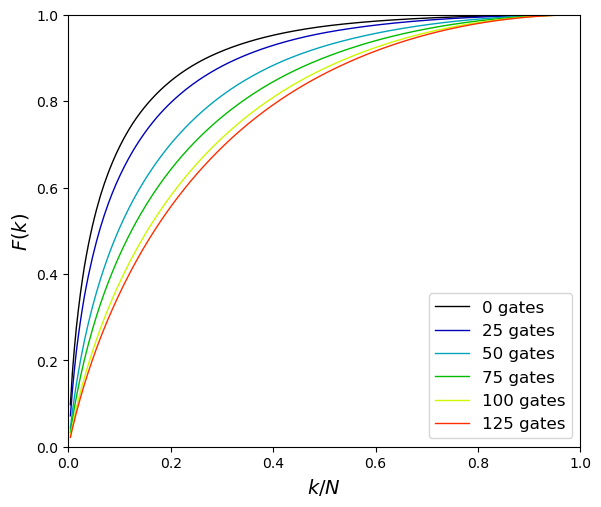

In [17]:
from qat.core.simutil import wavefunction
from qat.qpus import PyLinalg
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# this function calculates the probability vector given the wavefunction #
def get_probabilities(vector):
    for i in range(len(vector)):
        vector[i]=vector[i]*np.conj(vector[i])
    return np.real(vector)

# this function creates a np array with n1 sets of size n2 #
def empty_array(n1, n2):
    templist=[]
    for i in range(n1):
        templist.append(np.zeros(n2))
    return np.array(templist)
    
#this function calculates the cumulants#
def get_cumulants(probs):
    dim=np.shape(probs)
    cumulants=empty_array(dim[0], dim[1])
    for j in range(len(probs)):
        cumulant=0
        for i in range(len(probs[j])):
            sorted_probs=np.sort(probs[j])[::-1]
            cumulant=cumulant+sorted_probs[i]
            cumulants[j][i]=cumulant
    return cumulants

#this function calculates the fluctuations of the cumulants over many trials#
def get_fluctuations(all_cumulants):
    flucts=[]
    for i in range(all_cumulants.shape[1]):
        fluct=[]
        for j in range(all_cumulants.shape[2]):
            fluct.append(np.std(all_cumulants[:,i,j]))
        flucts.append(fluct)
    return np.array(flucts)


# Initial parameters #

nqbits=8 # the number of qubits #
batchsize=25 # the number of gates to be applied before measuring the wave function at each instance #
nsteps=6 # the number of times the the wave function will be measured #
trials=500
all_probs=[]

for k in range(trials):
    
    # Initializing stuff #
    
    my_program = Program()
    qbits_reg = my_program.qalloc(nqbits)
    qpu = PyLinalg()
    probs=empty_array(nsteps,2**nqbits) # the empty set which will contain the probability vectors #
    
    # Randomize the initial states of all qubits #
    
    my_program.apply(randomize_all(nqbits),qbits_reg)
    
    # Loop to apply the gates and measure the wavefunction #
    
    for i in range(nsteps):
        circuit = my_program.to_circ()
        wf=wavefunction(circuit, qpu) # calculate the wave function after n=batchsize gates applied #
        probs[i]=get_probabilities(wf) # save the associated probability vector in an array #
        my_program.apply(random_circuit(nqbits, batchsize, G1), qbits_reg)
        
    all_probs.append(probs)

# getting cumulants #

all_cumulants=[]

for x in all_probs:
    all_cumulants.append(get_cumulants(x))
        
all_cumulants=np.array(all_cumulants)

# calculating the average over all trials #

av_cumulants=sum(all_cumulants)/len(all_cumulants)
colors = pl.cm.nipy_spectral(np.linspace(0,1,7))

# Defining k/N #

rang=len(av_cumulants[0])+1
n=np.array(range(rang))/len(av_cumulants[0])
n=n[1:rang]

# plotting the Lorenz curves #

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])
l = 0
for i in range(len(av_cumulants)):
    ax.plot(n, av_cumulants[i], marker='', label=str(l)+' gates', c=colors[i], lw=1)
    l=l+batchsize
    
ax.set_xlim(0, 1)
ax.set_ylim(0, 1) 
ax.legend(fontsize=12)

# Add title and axis names
#plt.title('')
plt.xlabel(r'$k/N$', fontsize=14)
plt.ylabel(r'$F(k)$', fontsize=14)

## References
[1] Vallejos, R. & Melo, Fernando & Carlo, Gabriel. (2021). The principle of majorization: application to random quantum circuits.

[2] E. Ruch, The diagram lattice as structural principle, Theoretica Chimica Acta 38, 167 (1975).

[3] E. Ruch and A. Mead, The principle of increasing mixing character and some of its consequences, Theoretica Chimica Acta 41, 95 (1976).

[4] E. Ruch, R. Schranner, and T. H. Seligman, The mixing distance, The Journal of Chemical Physics 69, 386 (1978).

[5] R. Orús, J. I. Latorre, and M. A. Martín-Delgado, Natural majorization of the quantum fourier transformation in phase estimation algorithms, Quantum Information Processing 1, 283 (2002).

[6] J. I. Latorre and M. A. Martín-Delgado, Majorization arrow in quantum-algorithm design, Phys. Rev. A 66, 022305 (2002).

In [18]:
fig.savefig('majorizationprinciple.pdf', bbox_inches='tight')